In [4]:
#Libraries and other files are declared here
using DataFrames
using Distributions
using Graphs, Plots, GraphRecipes
using Random
using CSV
using Dates
include("create_data_functions.jl")

create_data (generic function with 1 method)

<span style="color:red">GLOBAL VARIABLES STARTS</span>

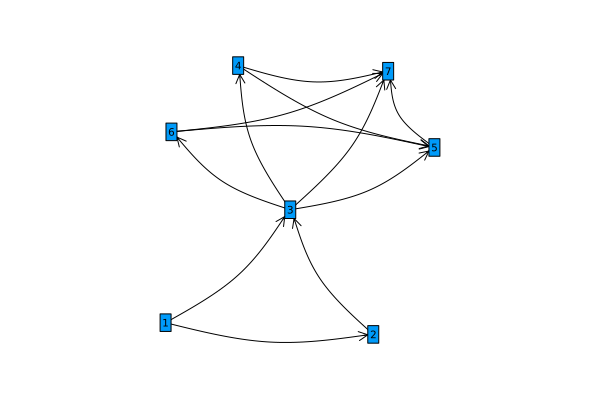

In [5]:
#Resourcelist: 
    #Resource 1: Auxiliary source node
    #Resource 2: Preprocessing
    #Resource 3: FMS
    #Resource 4: Post-processing 1
    #Resource 5: Quality control
    #Resource 6: Post-processing 2
    #Resource 7: Dispatch centre
#Those resources form a directed graph
#edges in graph are:
resource_edges = [(1,2), (1,3), (2,3), (3,4), (3,5), (3,6), (3,7), (4,5), (4,7), (5,7), (6,5), (6,7)] 
edge_flow = [0.5, 0.5, 1.0, 0.25, 0.25, 0.25, 0.25, 0.5, 0.5, 1.0, 0.5, 0.5]#How big proportion of activities from starting vertex flow through given edge 
res_flows = Dict(resource_edges[i] => edge_flow[i] for i in 1:length(resource_edges))

#Create simple directed graph that will be used to create all recipes
g = SimpleDiGraph(7);
for e in resource_edges
    add_edge!(g, e[1], e[2]);
end
graphplot(g, names=1:7, curves=true, nodeshape=:rect)

In [6]:
#All simple paths in directed graph, "recipes"
sp = collect(all_simple_paths(g, 1, 7))
sp_edges = [[(sp[j][i], sp[j][i+1]) for i in 1:length(sp[j])-1] for j in 1:length(sp)]; #Simple paths vector, edge-presentation

In [7]:
path_dict = Dict(i => sp[i] for i in 1:length(sp))

Dict{Int64, Vector{Int64}} with 12 entries:
  5  => [1, 2, 3, 6, 7]
  12 => [1, 3, 7]
  8  => [1, 3, 4, 7]
  1  => [1, 2, 3, 4, 5, 7]
  6  => [1, 2, 3, 7]
  11 => [1, 3, 6, 7]
  9  => [1, 3, 5, 7]
  3  => [1, 2, 3, 5, 7]
  7  => [1, 3, 4, 5, 7]
  4  => [1, 2, 3, 6, 5, 7]
  2  => [1, 2, 3, 4, 7]
  10 => [1, 3, 6, 5, 7]

In [8]:
#Calculate probability for each path
#Probability is used for generating job structure of order
path_probs_vec = Vector{Float64}()
for path in sp_edges
    values = [res_flows[edge] for edge in path if haskey(res_flows, edge)]
    prob = prod(values)
    path_probs_vec = append!(path_probs_vec, prob)
end
path_probs = Dict(path_dict[i] => path_probs_vec[i] for i in 1:length(sp));

In [9]:
#Join path index and probability
path_idx_prob = Dict(i => path_probs[path_dict[i]] for i in 1:length(path_probs));

<span style="color:red">GLOBAL VARIABLES END</span>

<span style="color:red">PARAMETERS STARTS</span>

In [14]:
#PARAMETERS
number_of_orders = 1000
arr_rate = 1
job_resource_mean = [1, 5, 5, 5, 8, 10, 1]
job_resource_CV = [1, 0.5, 0.3, 0.5, 0.5, 0.5, 0.5]
thres_coeff = 10 #Work content gamma distribution is truncated at x = thres_coeff * µ
duration_coefficient = [0, 3, 5, 3, 3, 3, 0] #Last element is zero because 
working_time_in_day = [0, 8, 24, 8, 8, 8, 8]
slack_coeff = 1
seed = 42

data_params = DataParameters(number_of_orders, arr_rate, job_resource_mean, job_resource_CV, thres_coeff, duration_coefficient, 
    working_time_in_day, slack_coeff, seed);

<span style="color:red">PARAMETERS END</span>

In [15]:
dataframe = create_data(data_params)

Row,Order,Job,Path,Arrival,Resource_idx,Resource_2,Resource_3,Resource_4,Resource_5,Resource_6,Resource_7,job_WC,Duration,MinDelivery,Slack,Duedate
,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Float64,Int64
1,1,1,9,1,3,0.0,5.98325,0.0,0.0,0.0,0.0,5.98325,2,6,6.0,13
2,1,2,9,1,5,0.0,0.0,0.0,3.99601,0.0,0.0,3.99601,2,6,6.0,13
3,1,3,9,1,7,0.0,0.0,0.0,0.0,0.0,0.577784,0.577784,2,6,6.0,13
4,2,4,6,2,2,8.1297,0.0,0.0,0.0,0.0,0.0,8.1297,4,7,7.0,16
5,2,5,6,2,3,0.0,4.45847,0.0,0.0,0.0,0.0,4.45847,1,7,7.0,16
6,2,6,6,2,7,0.0,0.0,0.0,0.0,0.0,0.702172,0.702172,2,7,7.0,16
7,3,7,6,3,2,1.79666,0.0,0.0,0.0,0.0,0.0,1.79666,1,5,5.0,13
8,3,8,6,3,3,0.0,5.01364,0.0,0.0,0.0,0.0,5.01364,2,5,5.0,13
9,3,9,6,3,7,0.0,0.0,0.0,0.0,0.0,1.20562,1.20562,2,5,5.0,13


<span style="color:red">SAVE THE DATA:</span> 

In [12]:
path = "data/input_data/"
date = Dates.format(today(), "dd-mm-yyyy")
filename = string("input_data_", date, "_seed_", seed, ".csv") #date + seed
fullpath = string(path, filename)

"data/input_data/input_data_01-11-2024_seed_42.csv"

In [13]:
CSV.write(fullpath,dataframe, delim = ";")

"data/input_data/input_data_01-11-2024_seed_42.csv"